In [2]:
import pandas as pd

# Đọc dữ liệu gốc từ file CSV
df = pd.read_csv(r'..\data\raw\traffic_accidents.csv')

# Lấy ngẫu nhiên 10 dòng từ dữ liệu
random_rows = df.sample(n=500, random_state=42)

# In ra các dòng ngẫu nhiên
print(random_rows)

# Hoặc nếu bạn muốn lưu các dòng ngẫu nhiên vào một file mới:
random_rows.to_csv('../data/new_data.csv', index=False)


                    crash_date traffic_control_device weather_condition  \
142002  06/01/2018 03:30:00 PM         TRAFFIC SIGNAL             CLEAR   
132434  07/19/2018 11:43:00 AM         TRAFFIC SIGNAL   CLOUDY/OVERCAST   
106970  07/04/2024 10:40:00 AM         TRAFFIC SIGNAL   CLOUDY/OVERCAST   
64659   10/13/2018 03:00:00 PM            NO CONTROLS             CLEAR   
107577  07/18/2024 01:36:00 PM            NO CONTROLS             CLEAR   
...                        ...                    ...               ...   
15158   09/28/2018 08:38:00 AM         TRAFFIC SIGNAL   CLOUDY/OVERCAST   
8325    01/25/2024 06:56:00 AM      STOP SIGN/FLASHER    FOG/SMOKE/HAZE   
71832   04/20/2019 08:20:00 PM      STOP SIGN/FLASHER             CLEAR   
42276   01/14/2020 05:40:00 PM         TRAFFIC SIGNAL             CLEAR   
73003   09/29/2018 09:25:00 PM      STOP SIGN/FLASHER              RAIN   

            lighting_condition          first_crash_type  \
142002                DAYLIGHT  SIDESWI

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Đọc dataset từ file CSV
df = pd.read_csv(r"..\data\simulated_crash_data.csv", encoding='utf-8')  # Thử với utf-8 hoặc ISO-8859-1

# Xóa cột "crash_date" nếu tồn tại
if "crash_date" in df.columns:
    df = df.drop(columns=["crash_date"])
    
true_labels = df['damage'].values

if "damage" in df.columns:
    df = df.drop(columns=["damage"])

# Các cột cần mã hóa
categorical_columns = [
    "traffic_control_device", "weather_condition", "lighting_condition", "first_crash_type", 
    "trafficway_type", "alignment", "roadway_surface_cond", "road_defect", "crash_type", 
    "intersection_related_i", "prim_contributory_cause", "most_severe_injury"
]

# Dictionary để lưu các label encoder
decoders = {}

# Mã hóa từng cột
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Thay đổi trực tiếp giá trị trong cột
    decoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))  # Lưu mapping cho báo cáo

# Lưu dataset đã mã hóa
df.to_csv('../data/new_data_cleaned_origin.csv', index=False)

In [4]:
import torch 
import pandas as pd 
import networkx as nx 
from itertools import combinations
from torch_geometric.data import Data 
from model import GAT

In [5]:
# Đọc dataset
file_path = r'..\data\new_data_cleaned_origin.csv'
df = pd.read_csv(file_path)

In [6]:
import networkx as nx
from itertools import combinations

G = nx.Graph()
for index, row in df.iterrows():
    G.add_node(index, **row.to_dict())

def is_similar(accident1, accident2):
    return (
        abs(accident1['crash_hour'] - accident2['crash_hour']) <= 1 or
        accident1['crash_month'] == accident2['crash_month'] or
        accident1['crash_day_of_week'] == accident2['crash_day_of_week'] or
        accident1['trafficway_type'] == accident2['trafficway_type'] or
        accident1['first_crash_type'] == accident2['first_crash_type'] or
        accident1['injuries_no_indication'] == accident2['injuries_no_indication']
    )

for u, v in combinations(G.nodes(data=True), 2):
    if is_similar(u[1], v[1]):
        G.add_edge(u[0], v[0])

print(f"Đã tạo đồ thị với {G.number_of_nodes()} nút và {G.number_of_edges()} cạnh.")


Đã tạo đồ thị với 500 nút và 49288 cạnh.


In [7]:
import torch
from torch_geometric.data import Data

def networkx_to_pyg_inference(G):
    feature_attrs = list(next(iter(G.nodes(data=True)))[1].keys())

    features = [
        [float(data[attr]) for attr in feature_attrs]
        for _, data in G.nodes(data=True)
    ]

    x = torch.tensor(features, dtype=torch.float)

    node_mapping = {node: i for i, node in enumerate(G.nodes())}
    edge_index = torch.tensor(
        [[node_mapping[u], node_mapping[v]] for u, v in G.edges()],
        dtype=torch.long
    ).t().contiguous()

    return Data(x=x, edge_index=edge_index)

data_new = networkx_to_pyg_inference(G)


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GAT(in_features=22, hidden_dim=16, out_features=3, heads=8).to(device)
model.load_state_dict(torch.load('gat_model.pth', map_location=device))
model.eval()


GAT(
  (gat1): GATConv(22, 16, heads=8)
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (gat2): GATConv(128, 16, heads=4)
  (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (gat3): GATConv(64, 3, heads=1)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [9]:
with torch.no_grad():
    out = model(data_new.x.to(device), data_new.edge_index.to(device))
    pred = out.argmax(dim=1)

df['predicted_damage'] = pred.cpu().numpy()

In [10]:
# Thêm giá trị predicted_damage vào đồ thị
for i, pred in enumerate(pred.cpu().numpy()):
    G.nodes[i]['predicted_damage'] = pred

# Kiểm tra lại giá trị đã được gán đúng chưa
for i in range(len(df)):
    print(f"Node {i} has predicted_damage = {G.nodes[i].get('predicted_damage')}")

Node 0 has predicted_damage = 0
Node 1 has predicted_damage = 0
Node 2 has predicted_damage = 0
Node 3 has predicted_damage = 0
Node 4 has predicted_damage = 0
Node 5 has predicted_damage = 0
Node 6 has predicted_damage = 0
Node 7 has predicted_damage = 0
Node 8 has predicted_damage = 0
Node 9 has predicted_damage = 0
Node 10 has predicted_damage = 0
Node 11 has predicted_damage = 0
Node 12 has predicted_damage = 0
Node 13 has predicted_damage = 0
Node 14 has predicted_damage = 0
Node 15 has predicted_damage = 0
Node 16 has predicted_damage = 0
Node 17 has predicted_damage = 0
Node 18 has predicted_damage = 0
Node 19 has predicted_damage = 0
Node 20 has predicted_damage = 0
Node 21 has predicted_damage = 0
Node 22 has predicted_damage = 0
Node 23 has predicted_damage = 0
Node 24 has predicted_damage = 0
Node 25 has predicted_damage = 0
Node 26 has predicted_damage = 0
Node 27 has predicted_damage = 0
Node 28 has predicted_damage = 0
Node 29 has predicted_damage = 0
Node 30 has predicte

In [11]:
# Mapping số về chuỗi như trong cột damage gốc
damage_mapping = {
    0: "$500 OR LESS",
    1: "$501 - $1,500",
    2: "OVER $1,500"
}

# Tạo cột mới với nhãn dạng chuỗi
df['predicted_damage_label'] = df['predicted_damage'].map(damage_mapping)

print(df[['predicted_damage', 'predicted_damage_label']])


     predicted_damage predicted_damage_label
0                   0           $500 OR LESS
1                   0           $500 OR LESS
2                   0           $500 OR LESS
3                   0           $500 OR LESS
4                   0           $500 OR LESS
..                ...                    ...
495                 1          $501 - $1,500
496                 1          $501 - $1,500
497                 1          $501 - $1,500
498                 1          $501 - $1,500
499                 1          $501 - $1,500

[500 rows x 2 columns]


In [12]:
from collections import Counter, defaultdict

def analyze_high_damage_nodes(G, label_attr='predicted_damage', high_level=1, top_k=3):
    # Bước 1: Lọc các node có predicted_damage bằng high_level
    high_damage_nodes = [n for n, data in G.nodes(data=True) if data.get(label_attr) == high_level]

    # Kiểm tra nếu không có node nào
    if not high_damage_nodes:
        print(f"No nodes found with {label_attr} = {high_level}")
        return

    # Bước 2: Thống kê các feature xuất hiện trong nhóm này
    feature_counters = defaultdict(Counter)

    for n in high_damage_nodes:
        node_data = G.nodes[n]
        for attr, value in node_data.items():
            if attr != label_attr:
                feature_counters[attr][value] += 1

    # Bước 3: In ra top K giá trị phổ biến nhất cho từng feature
    print(f"\nTop nguyên nhân thường thấy khi `{label_attr} = {high_level}`:\n")
    for attr, counter in feature_counters.items():
        print(f"- {attr}:")
        for val, freq in counter.most_common(top_k):
            print(f"   • {val}: {freq} lần")
        print()


In [13]:
analyze_high_damage_nodes(G, label_attr='predicted_damage', high_level=0)


Top nguyên nhân thường thấy khi `predicted_damage = 0`:

- traffic_control_device:
   • 10: 6 lần
   • 8: 6 lần
   • 4: 6 lần

- weather_condition:
   • 6: 9 lần
   • 13: 8 lần
   • 2: 8 lần

- lighting_condition:
   • 5: 18 lần
   • 3: 15 lần
   • 0: 15 lần

- first_crash_type:
   • 0: 9 lần
   • 13: 9 lần
   • 2: 6 lần

- trafficway_type:
   • 7: 8 lần
   • 9: 7 lần
   • 6: 6 lần

- alignment:
   • 2: 14 lần
   • 1: 14 lần
   • 5: 13 lần

- roadway_surface_cond:
   • 1: 11 lần
   • 8: 9 lần
   • 5: 8 lần

- road_defect:
   • 0: 16 lần
   • 7: 11 lần
   • 5: 9 lần

- crash_type:
   • 0: 39 lần
   • 1: 34 lần

- intersection_related_i:
   • 0: 39 lần
   • 1: 34 lần

- prim_contributory_cause:
   • 27: 4 lần
   • 16: 4 lần
   • 28: 4 lần

- num_units:
   • 8: 11 lần
   • 2: 9 lần
   • 10: 9 lần

- most_severe_injury:
   • 0: 17 lần
   • 4: 15 lần
   • 1: 14 lần

- injuries_total:
   • 18: 9 lần
   • 8: 9 lần
   • 16: 7 lần

- injuries_fatal:
   • 0: 24 lần
   • 2: 18 lần
   • 3: 16 lần

In [14]:
analyze_high_damage_nodes(G, label_attr='predicted_damage', high_level=1)


Top nguyên nhân thường thấy khi `predicted_damage = 1`:

- traffic_control_device:
   • 13: 30 lần
   • 6: 29 lần
   • 1: 29 lần

- weather_condition:
   • 5: 42 lần
   • 0: 40 lần
   • 12: 39 lần

- lighting_condition:
   • 0: 77 lần
   • 3: 76 lần
   • 5: 72 lần

- first_crash_type:
   • 14: 32 lần
   • 2: 31 lần
   • 8: 28 lần

- trafficway_type:
   • 10: 29 lần
   • 5: 29 lần
   • 4: 28 lần

- alignment:
   • 6: 74 lần
   • 4: 71 lần
   • 0: 63 lần

- roadway_surface_cond:
   • 3: 57 lần
   • 6: 53 lần
   • 5: 51 lần

- road_defect:
   • 0: 69 lần
   • 5: 59 lần
   • 6: 54 lần

- crash_type:
   • 1: 230 lần
   • 0: 197 lần

- intersection_related_i:
   • 1: 228 lần
   • 0: 199 lần

- prim_contributory_cause:
   • 6: 18 lần
   • 26: 17 lần
   • 37: 17 lần

- num_units:
   • 7: 58 lần
   • 8: 48 lần
   • 3: 42 lần

- most_severe_injury:
   • 1: 99 lần
   • 2: 83 lần
   • 4: 83 lần

- injuries_total:
   • 18: 29 lần
   • 9: 29 lần
   • 16: 26 lần

- injuries_fatal:
   • 1: 118 lần
  

In [15]:
analyze_high_damage_nodes(G, label_attr='predicted_damage', high_level=2)

No nodes found with predicted_damage = 2


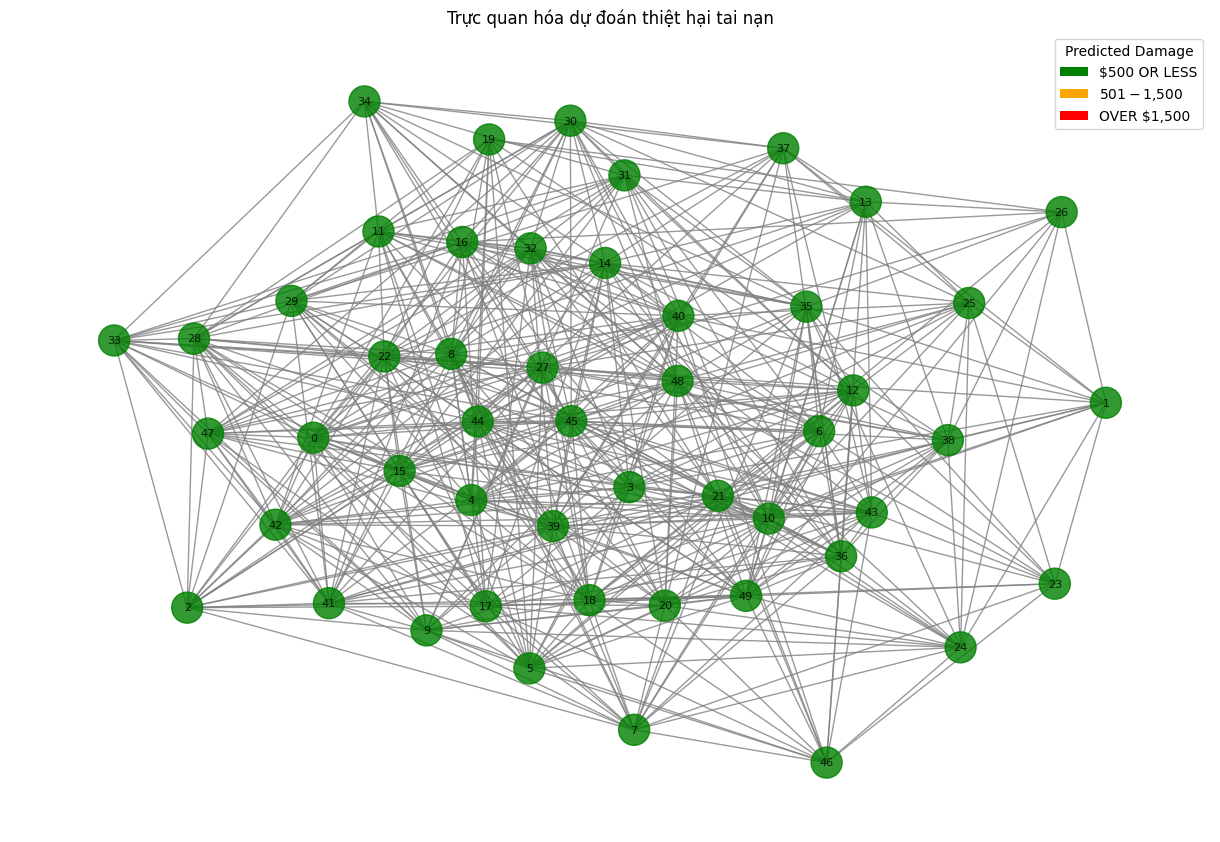

In [16]:
import matplotlib.pyplot as plt

# Gán nhãn dự đoán vào thuộc tính của node trong đồ thị
for idx, label in enumerate(df['predicted_damage']):
    G.nodes[idx]['predicted_damage'] = label

# Ánh xạ damage thành màu
color_map = {
    0: 'green',     # "$500 OR LESS"
    1: 'orange',    # "$501 - $1,500"
    2: 'red'        # "OVER $1,500"
}

# Tạo danh sách màu cho mỗi node
node_colors = [color_map[G.nodes[n]['predicted_damage']] for n in G.nodes]

# Tùy chọn: giảm số lượng node để dễ hiển thị (ví dụ chỉ 50 nodes)
sub_nodes = list(G.nodes)[:50]
subgraph = G.subgraph(sub_nodes)

# Vẽ đồ thị con với màu
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # layout đẹp hơn
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    node_color=[color_map[G.nodes[n]['predicted_damage']] for n in subgraph.nodes],
    node_size=500,
    font_size=8,
    edge_color='gray',
    alpha=0.8
)
# Tạo chú thích
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='$500 OR LESS'),
    Patch(facecolor='orange', label='$501 - $1,500'),
    Patch(facecolor='red', label='OVER $1,500'),
]
plt.legend(handles=legend_elements, title="Predicted Damage", loc='best')
plt.title("Trực quan hóa dự đoán thiệt hại tai nạn")
plt.axis('off')
plt.show()


Kết quả đánh giá ROC-AUC:
Lớp 0 ($500 OR LESS): 0.5305
Lớp 1 ($501 - $1,500): 0.5082
Lớp 2 (OVER $1,500): 0.5000
Trung bình: 0.5129


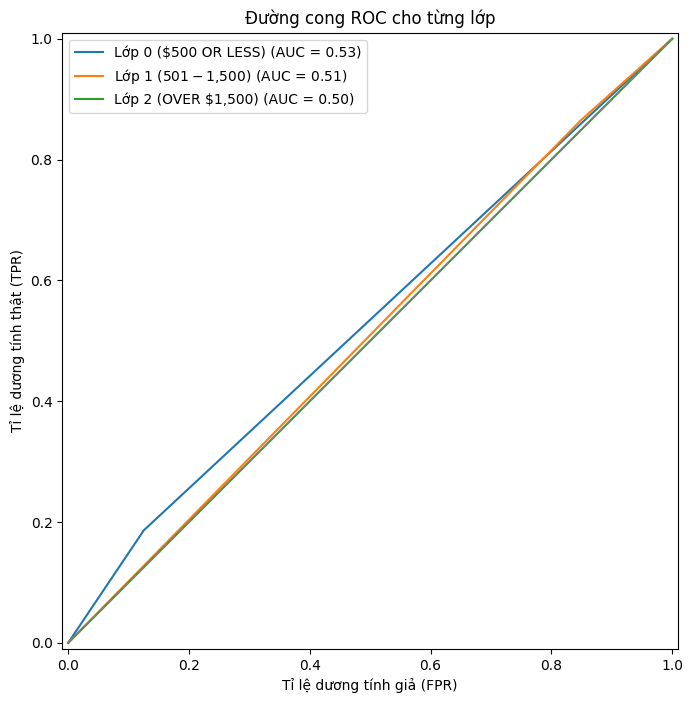

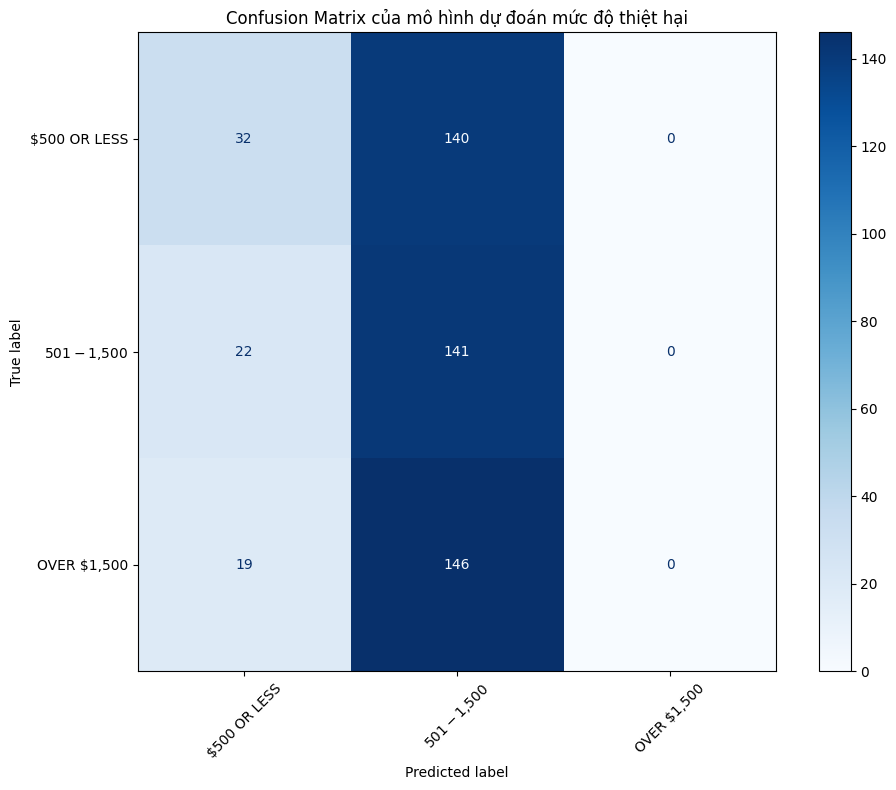


Phân tích Confusion Matrix:
- Độ chính xác cho $500 OR LESS: 18.60% (32/172)
- Độ chính xác cho $501 - $1,500: 86.50% (141/163)
- Độ chính xác cho OVER $1,500: 0.00% (0/165)

Báo cáo phân loại chi tiết:
               precision    recall  f1-score   support

 $500 OR LESS       0.44      0.19      0.26       172
$501 - $1,500       0.33      0.87      0.48       163
  OVER $1,500       0.00      0.00      0.00       165

     accuracy                           0.35       500
    macro avg       0.26      0.35      0.25       500
 weighted avg       0.26      0.35      0.25       500



c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Giả sử chúng ta có:
# - true_labels: nhãn thực tế (giá trị gốc từ cột 'damage')
# - df['predicted_damage']: dự đoán từ mô hình (đã được ánh xạ thành 0,1,2)

# Chuyển true_labels từ chuỗi sang số
damage_mapping = {
    '$500 OR LESS': 0,
    '$501 - $1,500': 1,
    'OVER $1,500': 2
}

# Chuyển đổi nhãn thực tế và dự đoán
true_labels_encoded = np.array([damage_mapping[label] for label in true_labels])
y_pred = df['predicted_damage'].values  # Đã là 0,1,2

# Binarize các nhãn cho ROC-AUC (cần cho multi-class)
y_true_bin = label_binarize(true_labels_encoded, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])

# Tính ROC-AUC cho từng lớp và trung bình
roc_auc_scores = {}
for i in range(3):
    roc_auc_scores[f"Lớp {i} ({list(damage_mapping.keys())[i]})"] = roc_auc_score(
        y_true_bin[:, i], 
        y_pred_bin[:, i]
    )
roc_auc_scores["Trung bình"] = roc_auc_score(
    y_true_bin, 
    y_pred_bin, 
    multi_class='ovr', 
    average='macro'
)

# In kết quả ROC-AUC
print("\nKết quả đánh giá ROC-AUC:")
for k, v in roc_auc_scores.items():
    print(f"{k}: {v:.4f}")

# Trực quan hóa ROC curves
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(3):
    RocCurveDisplay.from_predictions(
        y_true_bin[:, i],
        y_pred_bin[:, i],
        name=f"Lớp {i} ({list(damage_mapping.keys())[i]})",
        ax=ax
    )
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Đường cong ROC cho từng lớp')
plt.xlabel('Tỉ lệ dương tính giả (FPR)')
plt.ylabel('Tỉ lệ dương tính thật (TPR)')
plt.legend()
plt.show()

# Tính và hiển thị Confusion Matrix
cm = confusion_matrix(true_labels_encoded, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(damage_mapping.keys())
)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix của mô hình dự đoán mức độ thiệt hại')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Phân tích chi tiết Confusion Matrix
print("\nPhân tích Confusion Matrix:")
for i in range(3):
    total = sum(cm[i])
    correct = cm[i,i]
    accuracy = correct / total if total > 0 else 0
    print(f"- Độ chính xác cho {list(damage_mapping.keys())[i]}: {accuracy:.2%} ({correct}/{total})")

# Tính các chỉ số precision, recall, F1
print("\nBáo cáo phân loại chi tiết:")
print(classification_report(
    true_labels_encoded, 
    y_pred, 
    target_names=list(damage_mapping.keys())
))

In [18]:
from sklearn.metrics import accuracy_score, classification_report
from tabulate import tabulate
import pandas as pd

# Tính độ chính xác tổng thể
overall_accuracy = accuracy_score(true_labels_encoded, y_pred)

print("\n==============================================")
print(f"ĐỘ CHÍNH XÁC TỔNG THỂ CỦA MÔ HÌNH: {overall_accuracy:.2%}")
print("==============================================\n")

# Lấy báo cáo phân loại và chuyển sang dictionary
report = classification_report(
    true_labels_encoded, 
    y_pred, 
    target_names=list(damage_mapping.keys()),
    output_dict=True
)

# Hiển thị bảng tóm tắt các chỉ số đánh giá
metrics_table = []
for i, class_name in enumerate(damage_mapping.keys()):
    metrics_table.append([
        class_name,
        f"{report[class_name]['precision']:.2%}",
        f"{report[class_name]['recall']:.2%}",
        f"{report[class_name]['f1-score']:.2%}",
        report[class_name]['support']
    ])

# Thêm dòng tổng hợp
metrics_table.append([
    "MACRO AVG",
    f"{report['macro avg']['precision']:.2%}",
    f"{report['macro avg']['recall']:.2%}",
    f"{report['macro avg']['f1-score']:.2%}",
    report['macro avg']['support']
])

metrics_table.append([
    "WEIGHTED AVG",
    f"{report['weighted avg']['precision']:.2%}",
    f"{report['weighted avg']['recall']:.2%}",
    f"{report['weighted avg']['f1-score']:.2%}",
    report['weighted avg']['support']
])

print(tabulate(metrics_table, 
               headers=["Lớp", "Precision", "Recall", "F1-Score", "Số lượng mẫu"],
               tablefmt="grid",
               stralign="center",
               numalign="center"))

print("\nGhi chú:")
print("- Precision: Tỉ lệ dự đoán đúng trong tất cả các dự đoán thuộc lớp đó")
print("- Recall: Tỉ lệ mẫu thuộc lớp đó được dự đoán đúng")
print("- F1-Score: Trung bình điều hòa của Precision và Recall")
print("- Macro Avg: Trung bình đơn giản của các chỉ số")
print("- Weighted Avg: Trung bình có trọng số theo số lượng mẫu")

# Phân tích thêm về các trường hợp phân loại sai
error_analysis = pd.DataFrame({
    'Thực tế': [list(damage_mapping.keys())[x] for x in true_labels_encoded],
    'Dự đoán': [list(damage_mapping.keys())[x] for x in y_pred],
    'Đúng/Sai': true_labels_encoded == y_pred
})

error_cases = error_analysis[error_analysis['Đúng/Sai'] == False]
print("\n\nPHÂN TÍCH LỖI:")
print(f"Tổng số mẫu bị phân loại sai: {len(error_cases)}/{len(df)} ({len(error_cases)/len(df):.2%})")

# Ma trận nhầm lẫn giữa các lớp
confusion_pairs = error_cases.groupby(['Thực tế', 'Dự đoán']).size().unstack().fillna(0)
print("\nCHI TIẾT NHẦM LẪN GIỮA CÁC LỚP:")
print(confusion_pairs.to_string())

# Phân phối lớp
class_distribution = pd.Series([list(damage_mapping.keys())[x] for x in true_labels_encoded]).value_counts(normalize=True)
print("\nPHÂN PHỐI LỚP TRONG DỮ LIỆU:")
print(class_distribution.to_string())


ĐỘ CHÍNH XÁC TỔNG THỂ CỦA MÔ HÌNH: 34.60%

+---------------+-------------+----------+------------+----------------+
|      Lớp      |  Precision  |  Recall  |  F1-Score  |  Số lượng mẫu  |
+===============+=============+==========+============+================+
| $500 OR LESS  |   43.84%    |  18.60%  |   26.12%   |      172       |
+---------------+-------------+----------+------------+----------------+
| $501 - $1,500 |   33.02%    |  86.50%  |   47.80%   |      163       |
+---------------+-------------+----------+------------+----------------+
|  OVER $1,500  |    0.00%    |  0.00%   |   0.00%    |      165       |
+---------------+-------------+----------+------------+----------------+
|   MACRO AVG   |   25.62%    |  35.04%  |   24.64%   |      500       |
+---------------+-------------+----------+------------+----------------+
| WEIGHTED AVG  |   25.84%    |  34.60%  |   24.57%   |      500       |
+---------------+-------------+----------+------------+----------------+

Ghi ch

c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo